# Model 6b: GloVe + Mean Pooling + Logistic Regression

## 🎯 Objective:
Use pretrained GloVe word vectors to represent each headline as an average of its word embeddings. Train a simple classifier (Logistic Regression) on top.

## 🔧 Steps:
1. Import Libraries & Load Data
    - Load data.csv as usual
    - Prepare X_train, X_test, y_train, y_test

2. GloVe Model + Pooling
    - Load GloVe Embeddings (Download 100D)
    - Load GloVe into Dictionary

3. Model Training
    - Use LogisticRegression on the embedded vectors

5. Evaluation:
    - Accuracy, classification report

6. Confusion matrix

##  ✅ Purpose:
Leverage semantic-rich embeddings instead of hand-crafted features (TF-IDF). This gives a dense **representation of meaning**, and allows comparison with classical models from Model 0 and 2.

## 1. Import Librairies and load data

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("data/training_data_lowercase.csv", sep="\t", header=None, names=["label", "title"])
# data.reset_index(drop=True, inplace=True)  # optional

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df["title"], df["label"], test_size=0.2, random_state=42)

df.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


## 2. GloVe model + Pooling

### Load GloVe Embeddings (Download 100D)

In [ ]:
# Download GloVe if needed (100-dimensional vectors) ==> if it doesn't work, please download the glove.6B.zip file on "https://nlp.stanford.edu/projects/glove/" and add file golve.6B.100d.txt to your repository

'''!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip'''

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


### Load GloVe into Dictionary:

In [5]:
# Load GloVe vectors into a dictionary
glove_path = "data/glove.6B.100d.txt"
glove_dict = {}

with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_dict[word] = vector

print("GloVe loaded:", len(glove_dict), "words")

GloVe loaded: 400000 words


## 3. Preprocess and Embed Sentences

In [6]:
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().split()

def sentence_to_vec(sentence, embeddings, dim=100):
    words = preprocess_text(sentence)
    vectors = [embeddings[word] for word in words if word in embeddings]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

# Embed all titles
X_train_vec = np.vstack([sentence_to_vec(s, glove_dict) for s in X_train])
X_test_vec = np.vstack([sentence_to_vec(s, glove_dict) for s in X_test])

## 4. Train Logistic Regression:

In [7]:
# Model training
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

## 5. Evaluation:

In [8]:
# Evaluation
y_pred = clf.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8896208461425853
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      3529
           1       0.89      0.88      0.89      3302

    accuracy                           0.89      6831
   macro avg       0.89      0.89      0.89      6831
weighted avg       0.89      0.89      0.89      6831



## 5. Confusion Matrix Plot:

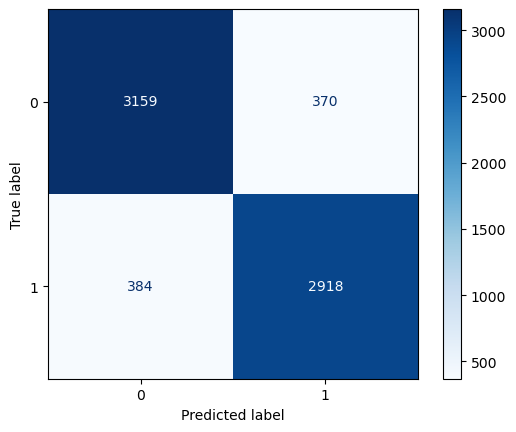

In [9]:
# Optional: show confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test_vec, y_test, cmap="Blues")